In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np
import gc

gc.enable()

Load Datasets

In [2]:
train_data = pd.read_csv('cleaned_train.csv')
test_data = pd.read_csv('cleaned_test.csv')

MemoryError: Unable to allocate 128. KiB for an array with shape (16384,) and data type int64

Feature selection

In [3]:
correlation_matrix = train_data.corr(numeric_only=True)

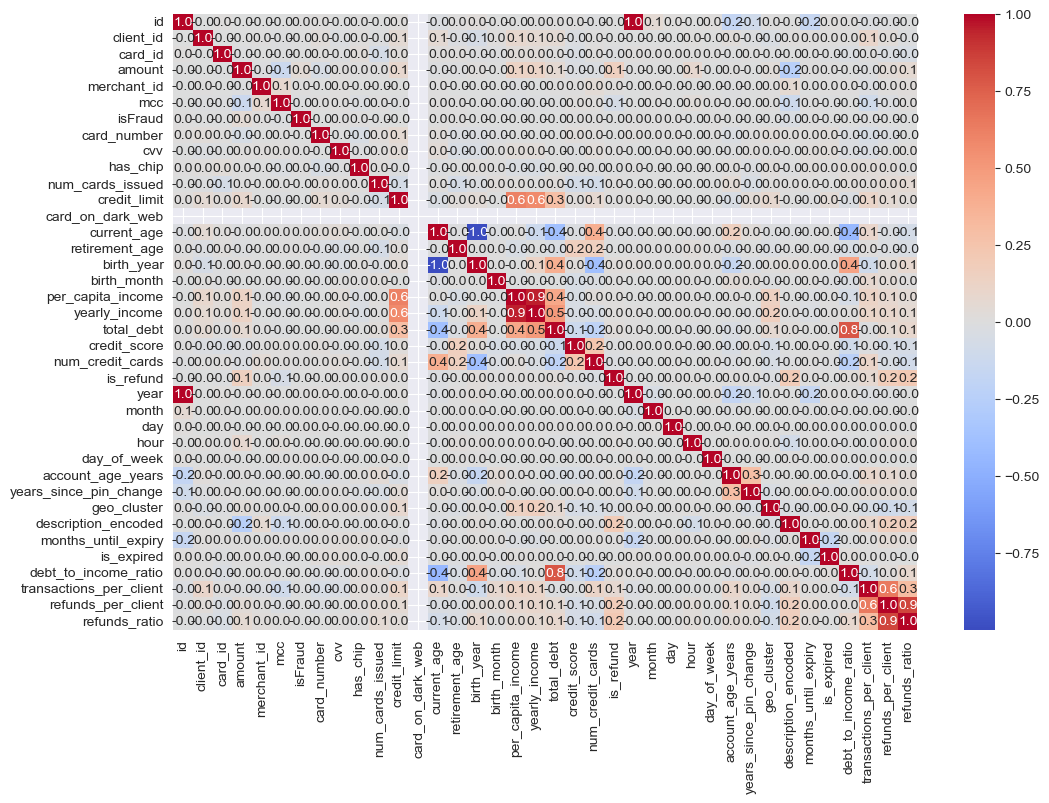

In [4]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f')
plt.show()

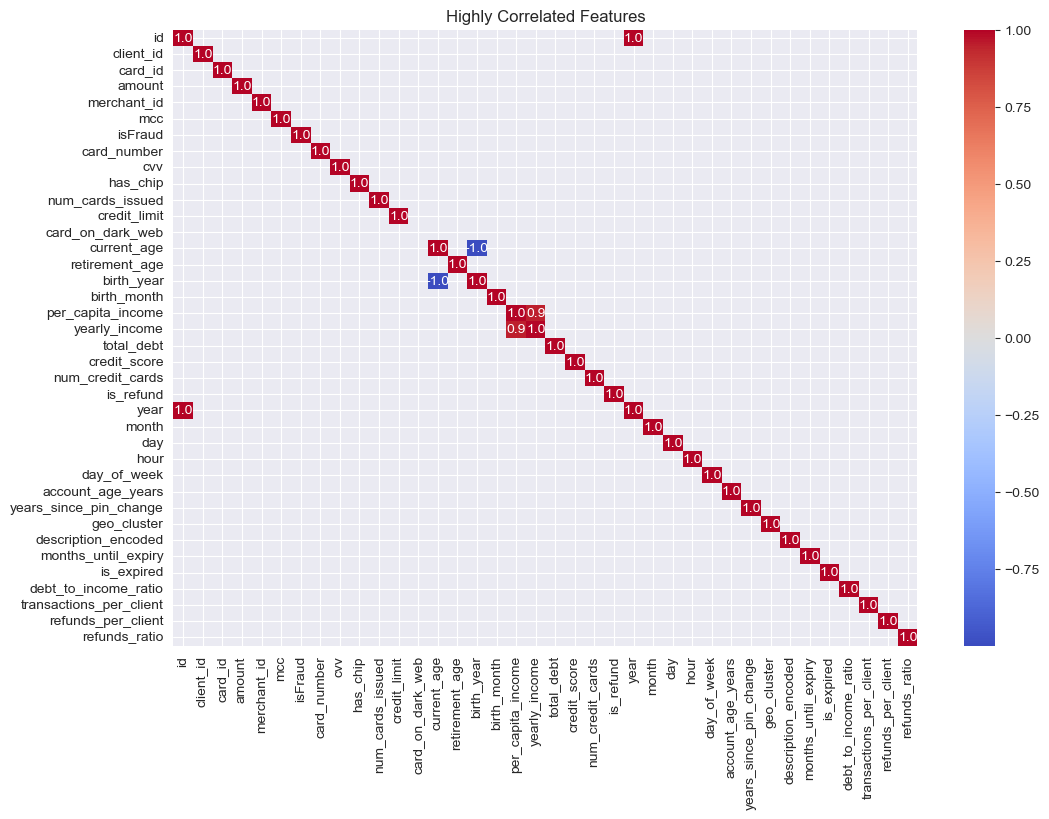

In [5]:
# Identify highly correlated features (absolute correlation > 0.9)
high_corr = correlation_matrix[correlation_matrix.abs() > 0.9]
plt.figure(figsize=(12, 8))
sns.heatmap(high_corr, annot=True, cmap="coolwarm", fmt='.1f')
plt.title("Highly Correlated Features")
plt.show()

Drop one from each highly correlated pair

In [7]:
# Drop obsolete columns from the training and test datasets
train_data = train_data.drop(columns=['birth_year', 'per_capita_income','birth_month'])
test_data = test_data.drop(columns=['birth_year', 'per_capita_income','birth_month'])

In [8]:
# Correlation of features with isFraud
target_corr = train_data.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)
print("Top correlations with isFraud:\n", target_corr.head(10))

Top correlations with isFraud:
 isFraud                1.000000
amount                 0.040125
num_credit_cards       0.006799
merchant_id            0.005827
current_age            0.004423
day_of_week            0.003861
month                  0.001895
has_chip               0.001301
months_until_expiry    0.001024
credit_score           0.000827
Name: isFraud, dtype: float64


In [9]:
correlation_matrix = train_data.corr(numeric_only=True)

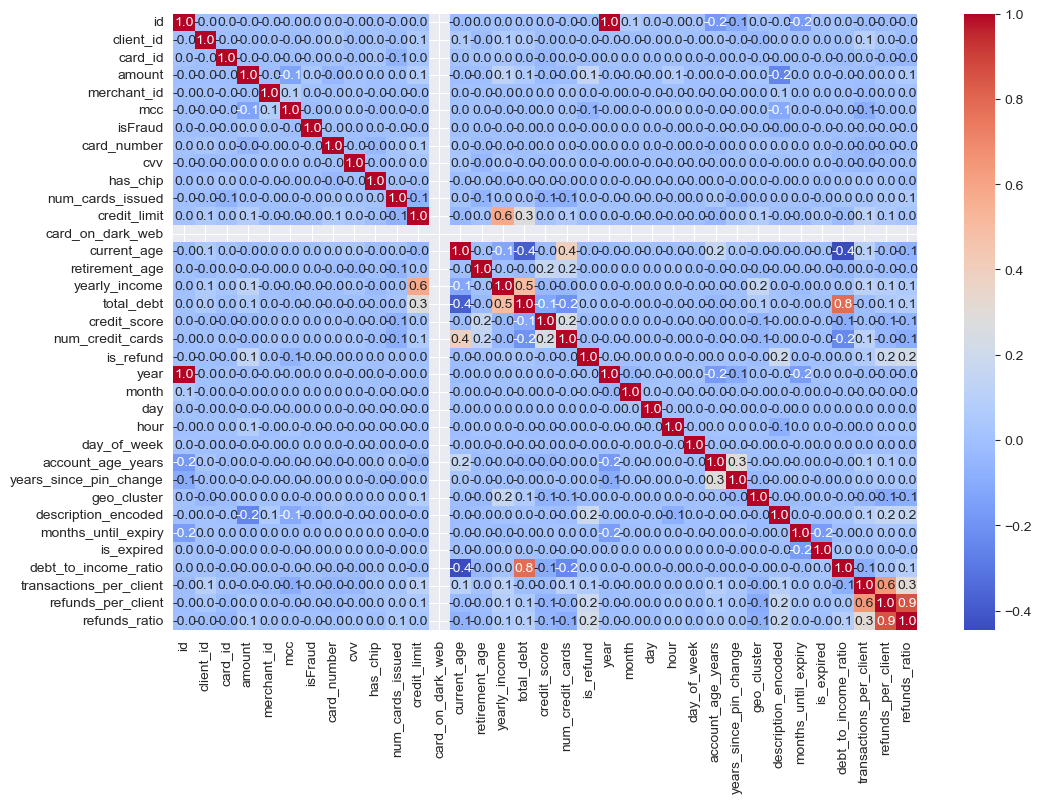

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f')
plt.show()

# Feature Selection - Chi-Square for categorical features and ANOVA for numerical features

In [12]:
# Separate features and target variable
X_train = train_data.drop(columns=['isFraud', 'id', 'date', 'card_number', 'cvv', 'zip','client_id','card_id','merchant_id','gender','months_until_expiry'])
y_train = train_data['isFraud']

# Categorical columns
categorical_cols = X_train.select_dtypes(include=['category','object']).columns  # 'object' is for string columns
additional_categorical_cols = ['card_on_dark_web', 'description_encoded', 'has_chip','is_refund','is_expired']
categorical_cols = categorical_cols.union(additional_categorical_cols)

# Encode categorical columns using LabelEncoder
encoder = LabelEncoder()

# Apply encoding to categorical features
for col in categorical_cols:
    X_train[col] = encoder.fit_transform(X_train[col].astype(str))  # Ensure all values are strings for encoding

# Perform Chi-Square Test for Categorical Features
chi2_results = chi2(X_train[categorical_cols], y_train)

# Collect p-values and feature names
chi2_p_values = pd.Series(chi2_results[1], index=X_train[categorical_cols].columns)
chi2_significant_features = chi2_p_values[chi2_p_values < 0.05].index.tolist()

print("Significant (Chi-Square Test):")
print(chi2_significant_features)

# Numerical columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns
# Get the intersection of numeric and categorical columns
numeric_and_categorical_overlap = numerical_cols.intersection(categorical_cols)

# Exclude overlapping columns from the numeric columns
numerical_cols = numerical_cols.difference(numeric_and_categorical_overlap)

# Perform ANOVA (F-test) for Numerical Features
f_values, p_values = f_classif(X_train[numerical_cols], y_train)

# Collect p-values and feature names
anova_p_values = pd.Series(p_values, index=numerical_cols)
anova_significant_features = anova_p_values[anova_p_values < 0.05].index.tolist()

print("\nSignificant (ANOVA Test):")
print(anova_significant_features)

# Combine both categorical and numerical significant features
significant_features = chi2_significant_features + anova_significant_features

# Keep only the significant features in the training dataset
X_train_selected = X_train[significant_features]

print(f"\nRetained Features after Feature Selection: {significant_features}")

Significant Categorical Features (Chi-Square Test):
['address', 'card_brand', 'description_encoded', 'errors', 'is_expired', 'is_refund', 'merchant_city', 'merchant_state', 'use_chip']

Significant Numerical Features (ANOVA Test):
['account_age_years', 'amount', 'credit_limit', 'credit_score', 'current_age', 'day_of_week', 'debt_to_income_ratio', 'hour', 'mcc', 'month', 'num_credit_cards', 'refunds_per_client', 'refunds_ratio', 'total_debt', 'transactions_per_client', 'yearly_income']

Retained Features after Feature Selection: ['address', 'card_brand', 'description_encoded', 'errors', 'is_expired', 'is_refund', 'merchant_city', 'merchant_state', 'use_chip', 'account_age_years', 'amount', 'credit_limit', 'credit_score', 'current_age', 'day_of_week', 'debt_to_income_ratio', 'hour', 'mcc', 'month', 'num_credit_cards', 'refunds_per_client', 'refunds_ratio', 'total_debt', 'transactions_per_client', 'yearly_income']


In [27]:
for i in ['isFraud', 'id', 'date', 'card_number', 'cvv', 'zip','client_id','card_id','merchant_id','gender','months_until_expiry']:
    significant_features.append(i)

In [ ]:
train_data = train_data[significant_features]
test_data = test_data[significant_features - 'isFraud']

Visualizations & Analysis

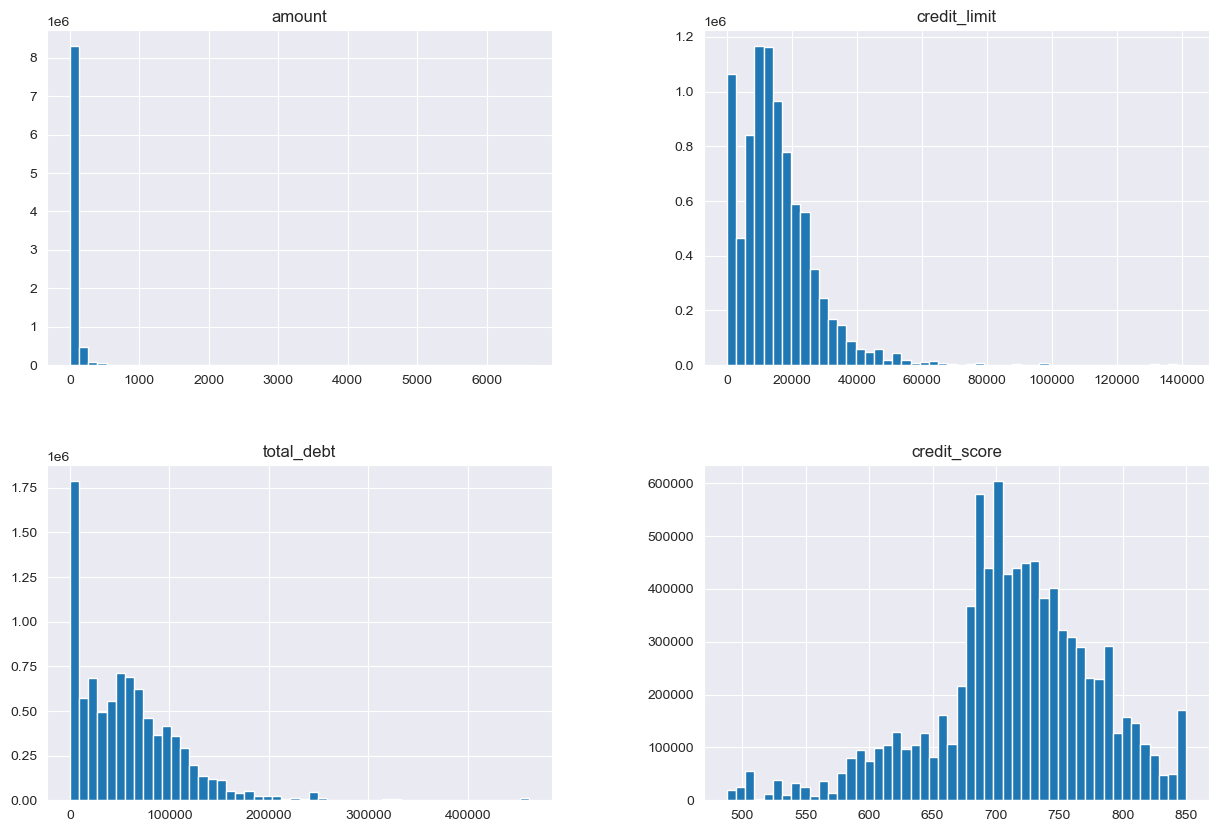

In [15]:
# Plot histograms for numerical columns
numerical_columns = ['amount', 'credit_limit', 'total_debt', 'credit_score']
train_data[numerical_columns].hist(bins=50, figsize=(15, 10))
plt.show()

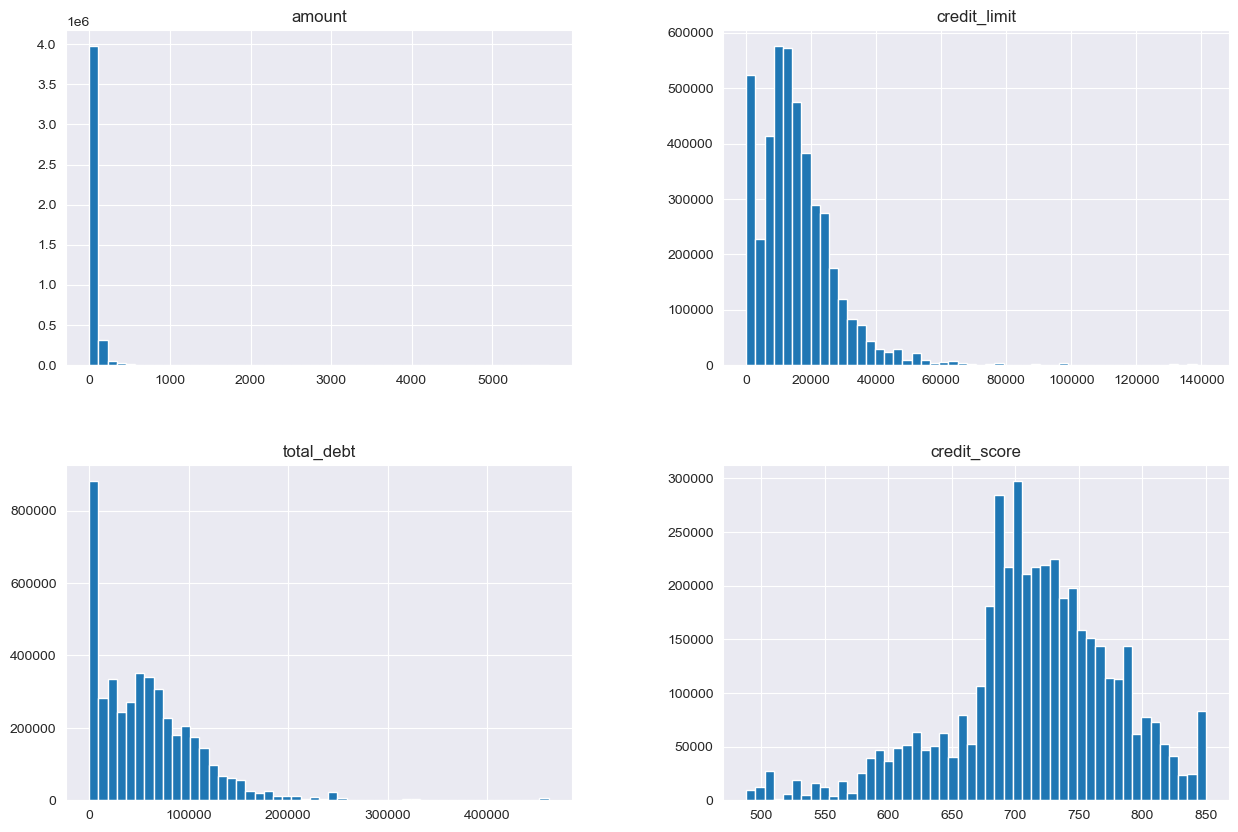

In [16]:
# Plot histograms for numerical columns
numerical_columns = ['amount', 'credit_limit', 'total_debt', 'credit_score']
test_data[numerical_columns].hist(bins=50, figsize=(15, 10))
plt.show()

Similar spreads of data for test and train sets which is a positive indication that it will predict reliably!

In [17]:
# Summary statistics for numerical columns
print(train_data.describe())

# Frequency counts for categorical features
categorical_cols = ['use_chip', 'card_brand', 'card_type', 'gender', 'merchant_state']
for col in categorical_cols:
    print(f"{col} value counts:\n", train_data[col].value_counts())

                 id     client_id       card_id        amount   merchant_id  \
count  8.914963e+06  8.914963e+06  8.914963e+06  8.914963e+06  8.914963e+06   
mean   1.558473e+07  1.026637e+03  3.474887e+03  5.311870e+01  4.772566e+04   
std    4.703991e+06  5.816755e+02  1.674427e+03  7.529693e+01  2.581623e+04   
min    7.475327e+06  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    1.150786e+07  5.190000e+02  2.413000e+03  1.175000e+01  2.588700e+04   
50%    1.557140e+07  1.070000e+03  3.584000e+03  3.481000e+01  4.592600e+04   
75%    1.965387e+07  1.530000e+03  4.899000e+03  7.097000e+01  6.757000e+04   
max    2.376187e+07  1.998000e+03  6.138000e+03  6.613440e+03  1.003420e+05   

                mcc       isFraud   card_number           cvv      has_chip  \
count  8.914963e+06  8.914963e+06  8.914963e+06  8.914963e+06  8.914963e+06   
mean   5.565097e+03  1.495463e-03  4.817349e+15  4.953292e+02  8.999044e-01   
std    8.755078e+02  3.864230e-02  1.311465e+15  2.

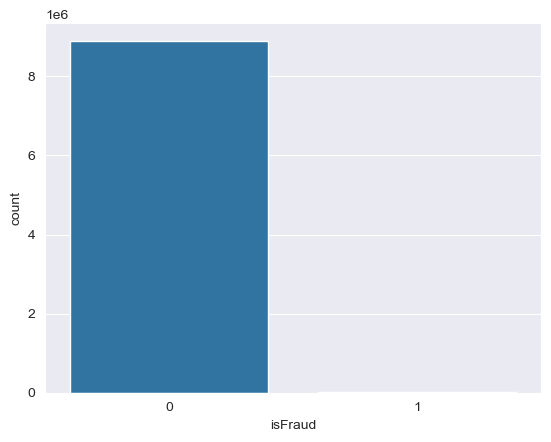

In [18]:
# Bar plot for fraud distribution
sns.countplot(x='isFraud', data=train_data)
plt.show()

In [19]:
print(train_data['isFraud'].value_counts())

isFraud
0    8901631
1      13332
Name: count, dtype: int64


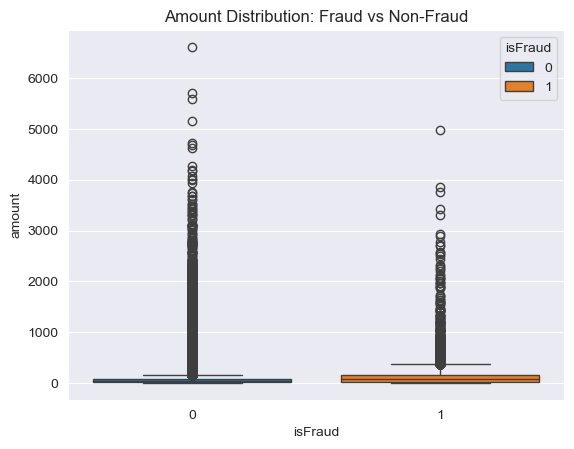

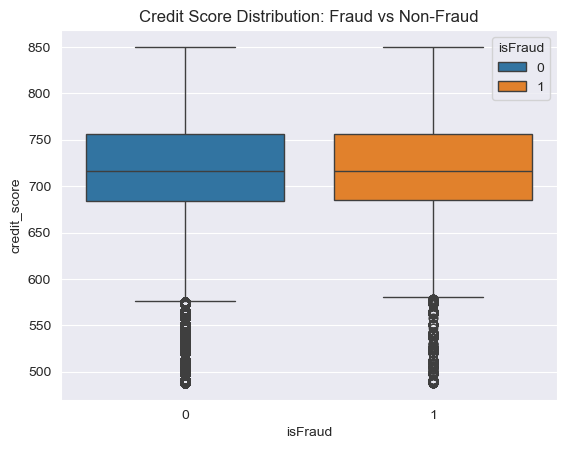

In [20]:
# Plot amount distribution for fraud vs non-fraud transactions
sns.boxplot(x='isFraud', y='amount', data=train_data, hue='isFraud')
plt.title('Amount Distribution: Fraud vs Non-Fraud')
plt.show()

# Compare credit_score distribution
sns.boxplot(x='isFraud', y='credit_score', data=train_data, hue='isFraud')
plt.title('Credit Score Distribution: Fraud vs Non-Fraud')
plt.show()

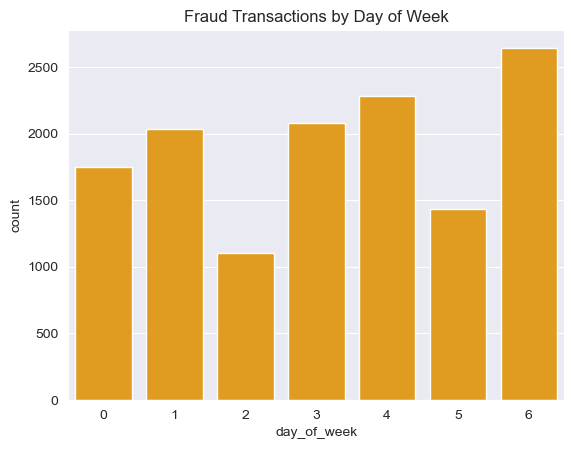

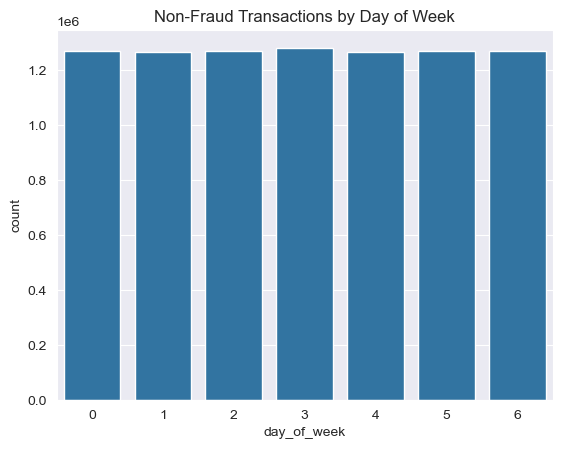

In [21]:
# Separate count plot for fraud transactions
sns.countplot(x='day_of_week', data=train_data[train_data['isFraud'] == 1], color='orange')
plt.title('Fraud Transactions by Day of Week')
plt.show()

# Separate count plot for non-fraud transactions
sns.countplot(x='day_of_week', data=train_data[train_data['isFraud'] == 0])
plt.title('Non-Fraud Transactions by Day of Week')
plt.show()

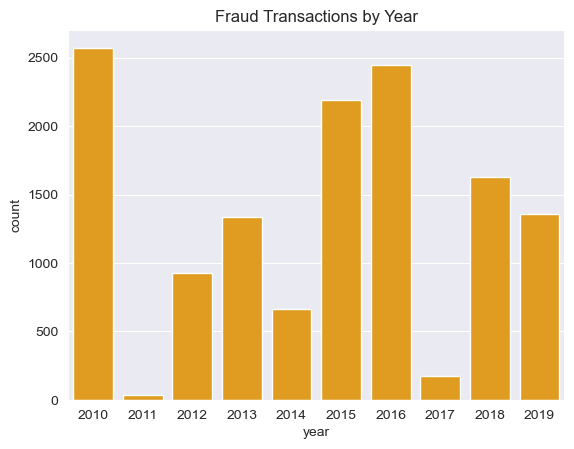

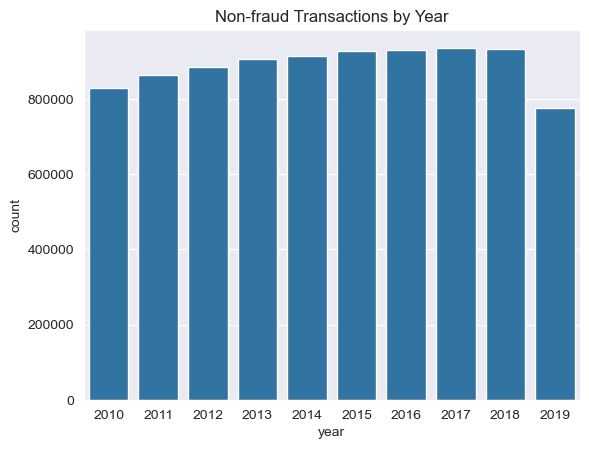

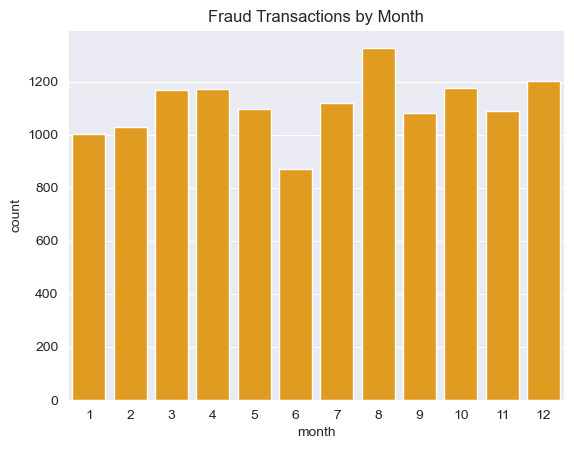

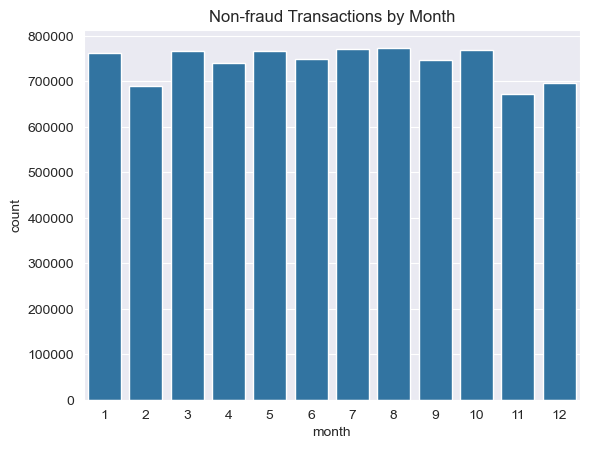

In [22]:
# Convert 'date' to datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

# Add year and month columns
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month

# Plot fraud trends by year
sns.countplot(x='year', data=train_data[train_data['isFraud'] == 1],color='orange')
plt.title('Fraud Transactions by Year')
plt.show()

# Plot fraud trends by year
sns.countplot(x='year', data=train_data[train_data['isFraud'] == 0])
plt.title('Non-fraud Transactions by Year')
plt.show()

# Plot fraud trends by month
sns.countplot(x='month', data=train_data[train_data['isFraud'] == 1],color='orange')
plt.title('Fraud Transactions by Month')
plt.show()

# Plot fraud trends by month
sns.countplot(x='month', data=train_data[train_data['isFraud'] == 0])
plt.title('Non-fraud Transactions by Month')
plt.show()

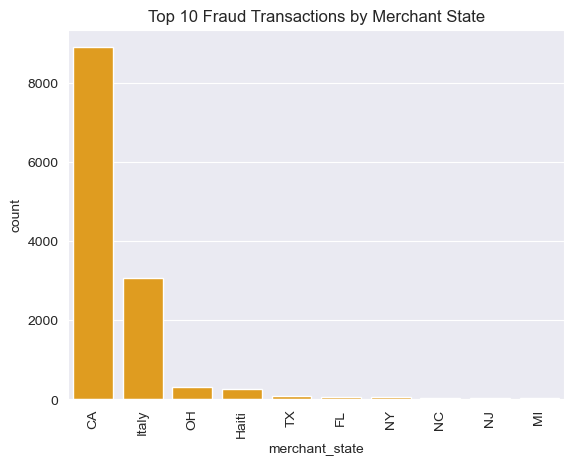

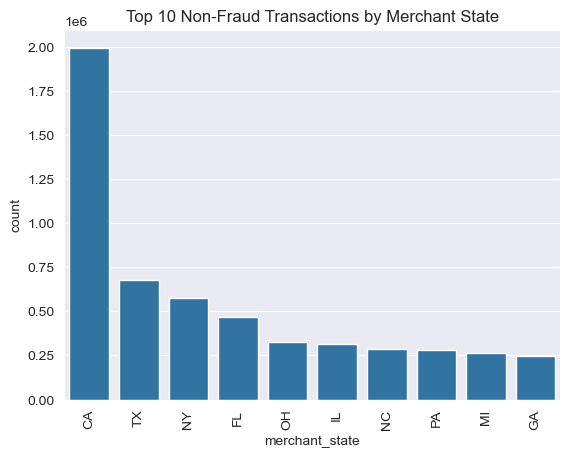

In [23]:
# Filter out "unknown" states
train_data_fraud = train_data[(train_data['isFraud'] == 1) & (train_data['merchant_state'] != 'Unknown')]
train_data_non_fraud = train_data[(train_data['isFraud'] == 0) & (train_data['merchant_state'] != 'Unknown')]

# Get top 10 most frequent merchant states for fraud transactions
top_states_fraud = train_data_fraud['merchant_state'].value_counts().nlargest(10).index
sns.countplot(x='merchant_state', data=train_data_fraud, order=top_states_fraud, color='orange')
plt.title('Top 10 Fraud Transactions by Merchant State')
plt.xticks(rotation=90)
plt.show()

# Get top 10 most frequent merchant states for non-fraud transactions
top_states_non_fraud = train_data_non_fraud['merchant_state'].value_counts().nlargest(10).index
sns.countplot(x='merchant_state', data=train_data_non_fraud, order=top_states_non_fraud)
plt.title('Top 10 Non-Fraud Transactions by Merchant State')
plt.xticks(rotation=90)
plt.show()

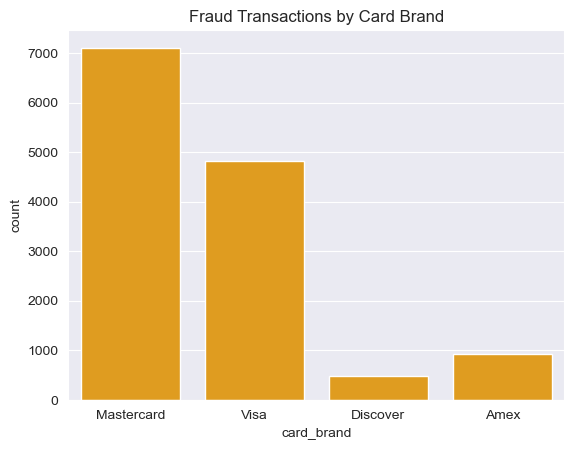

MemoryError: Unable to allocate 67.9 MiB for an array with shape (8901631, 1) and data type datetime64[ns]

In [25]:
# Separate count plot for fraud transactions by card brand
sns.countplot(x='card_brand', data=train_data[train_data['isFraud'] == 1], color='orange')
plt.title('Fraud Transactions by Card Brand')
plt.show()

# Separate count plot for non-fraud transactions by card brand
sns.countplot(x='card_brand', data=train_data[train_data['isFraud'] == 0])
plt.title('Non-Fraud Transactions by Card Brand')
plt.show()

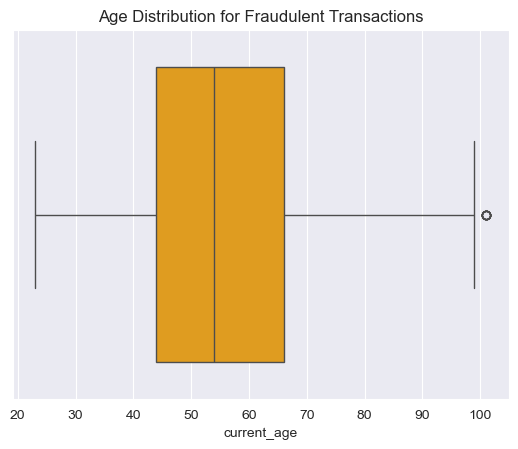

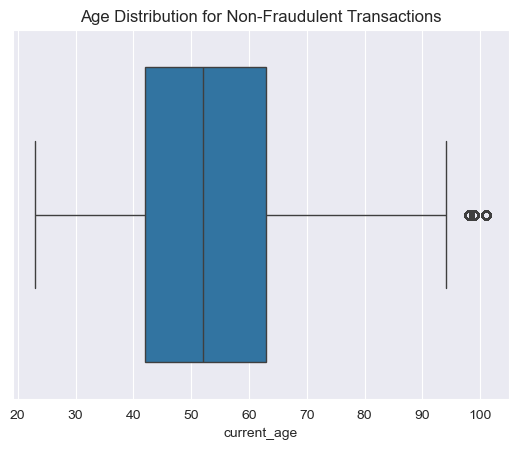

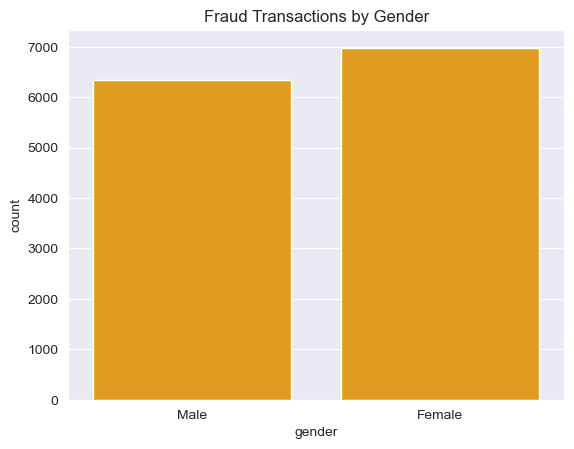

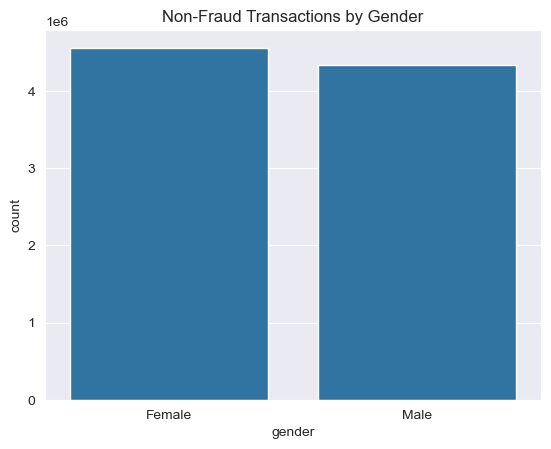

In [20]:
# Separate boxplot for fraud transactions by age
sns.boxplot(x='current_age', data=train_data[train_data['isFraud'] == 1], color='orange')
plt.title('Age Distribution for Fraudulent Transactions')
plt.show()

# Separate boxplot for non-fraud transactions by age
sns.boxplot(x='current_age', data=train_data[train_data['isFraud'] == 0])
plt.title('Age Distribution for Non-Fraudulent Transactions')
plt.show()

# Separate count plot for fraud vs non-fraud by gender
sns.countplot(x='gender', data=train_data[train_data['isFraud'] == 1], color='orange')
plt.title('Fraud Transactions by Gender')
plt.show()

sns.countplot(x='gender', data=train_data[train_data['isFraud'] == 0])
plt.title('Non-Fraud Transactions by Gender')
plt.show()

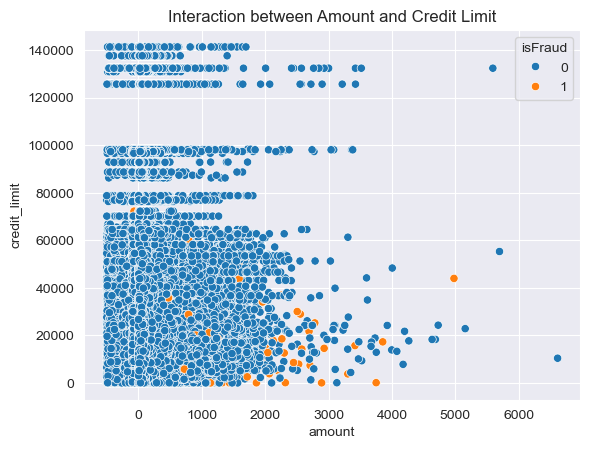

In [21]:
# Scatter plot to check interaction between amount and credit_limit
sns.scatterplot(x='amount', y='credit_limit', hue='isFraud', data=train_data)
plt.title('Interaction between Amount and Credit Limit')
plt.show()

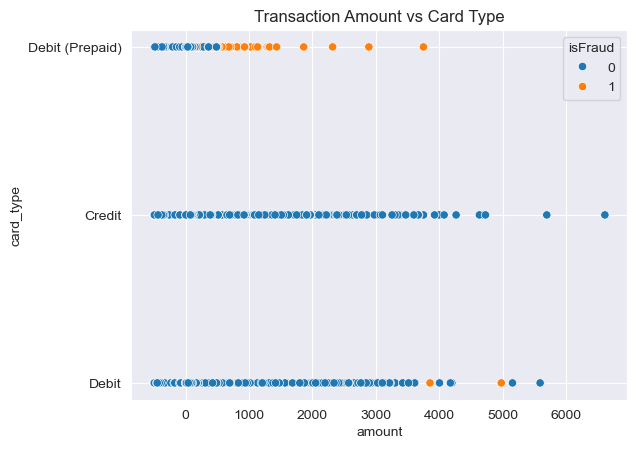

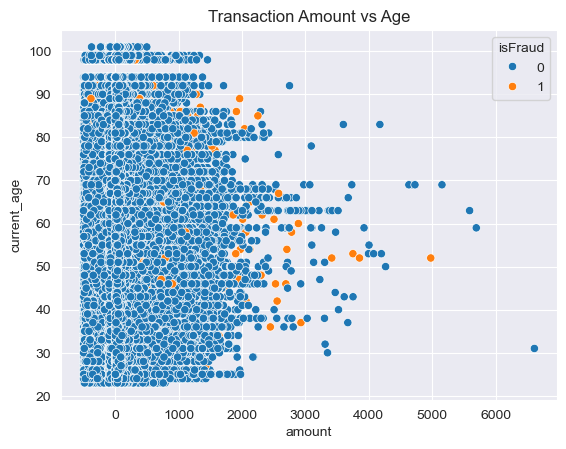

In [22]:
# Scatter plot for transaction amount vs. card_type
sns.scatterplot(x='amount', y='card_type', hue='isFraud', data=train_data)
plt.title('Transaction Amount vs Card Type')
plt.show()

# Scatter plot for transaction amount vs. age
sns.scatterplot(x='amount', y='current_age', hue='isFraud', data=train_data)
plt.title('Transaction Amount vs Age')
plt.show()

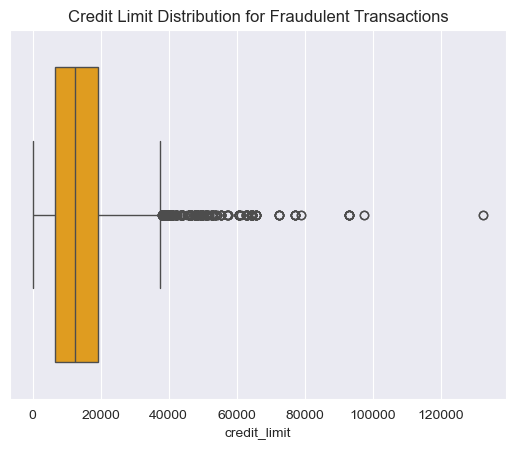

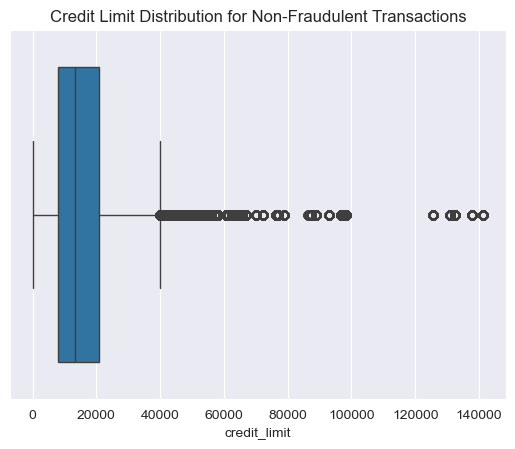

In [23]:
# Separate boxplot for fraud transactions by credit_limit
sns.boxplot(x='credit_limit', data=train_data[train_data['isFraud'] == 1], color='orange')
plt.title('Credit Limit Distribution for Fraudulent Transactions')
plt.show()

# Separate boxplot for non-fraud transactions by credit_limit
sns.boxplot(x='credit_limit', data=train_data[train_data['isFraud'] == 0])
plt.title('Credit Limit Distribution for Non-Fraudulent Transactions')
plt.show()

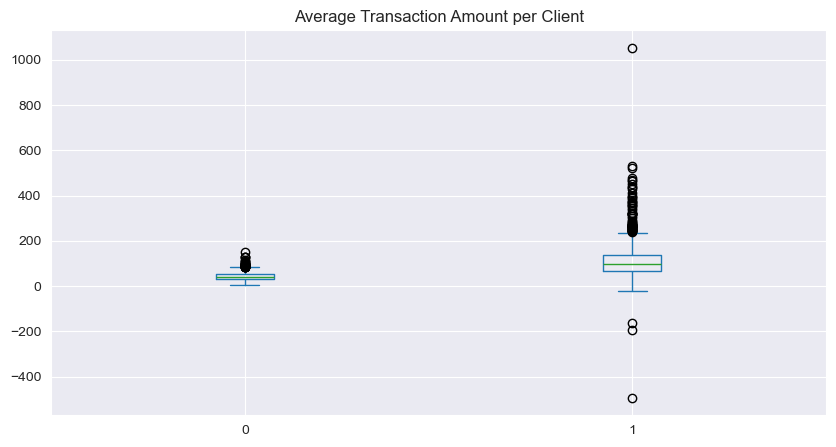

In [24]:
# Average transaction amount per client for fraud vs non-fraud
client_fraud_amount = train_data.groupby(['client_id', 'isFraud'])['amount'].mean().unstack()
client_fraud_amount.plot(kind='box', figsize=(10, 5))
plt.title("Average Transaction Amount per Client")
plt.show()

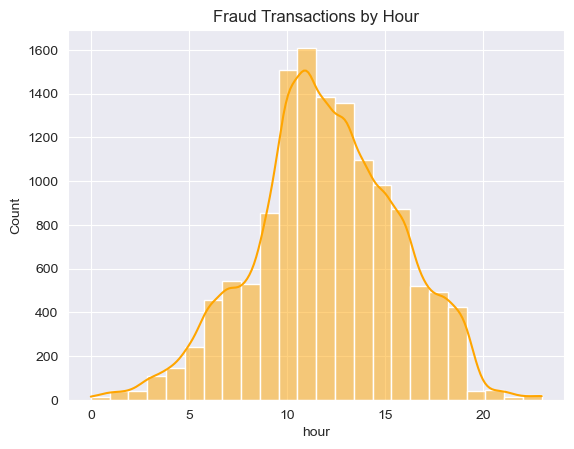

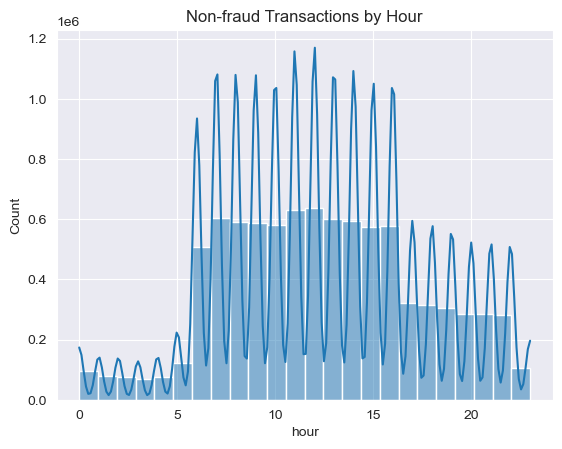

In [25]:
# Transactions by hour for fraud vs non-fraud
sns.histplot(x='hour', data=train_data[train_data['isFraud'] == 1], color='orange', kde=True, bins=24)
plt.title("Fraud Transactions by Hour")
plt.show()

sns.histplot(x='hour', data=train_data[train_data['isFraud'] == 0], kde=True, bins=24)
plt.title("Non-fraud Transactions by Hour")
plt.show()

Feature encoding

In [26]:
# List of categorical columns to encode
categorical_cols = ['use_chip', 'merchant_city', 'merchant_state', 'card_brand', 'card_type', 'gender']

# Apply frequency encoding for each categorical column
for col in categorical_cols:
    # Calculate frequency of each category
    freq_map = train_data[col].value_counts(normalize=True)

    # Map frequency values to the training and test datasets
    train_data[col + '_encoded'] = train_data[col].map(freq_map)
    test_data[col + '_encoded'] = test_data[col].map(freq_map)

    print(train_data.head())

            use_chip merchant_city merchant_state  card_brand  \
0  Swipe Transaction        Beulah             ND  Mastercard   
1  Swipe Transaction    Bettendorf             IA  Mastercard   
2  Swipe Transaction         Vista             CA  Mastercard   
3  Swipe Transaction       Harwood             MD        Visa   
4  Swipe Transaction         Bronx             NY  Mastercard   

         card_type  gender  
0  Debit (Prepaid)  Female  
1           Credit    Male  
2            Debit    Male  
3            Debit    Male  
4  Debit (Prepaid)  Female  
             use_chip merchant_city merchant_state  card_brand  \
0   Swipe Transaction   Crown Point             IN  Mastercard   
1   Swipe Transaction        Beulah             ND  Mastercard   
2  Online Transaction        ONLINE        Unknown        Visa   
3   Swipe Transaction      Flushing             NY  Mastercard   
4   Swipe Transaction    San Benito             TX  Mastercard   

         card_type  gender  
0        

Feature scaling

In [28]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# List of numerical columns to scale
numerical_cols = ['amount', 'credit_limit', 'total_debt', 'credit_score',
                  'debt_to_income_ratio', 'transactions_per_client']
# Scale numerical columns while keeping the original columns
for col in numerical_cols:
    train_data[f"{col}_scaled"] = scaler.fit_transform(train_data[[col]])
    test_data[f"{col}_scaled"] = scaler.transform(test_data[[col]])

# Verify scaled columns
print(train_data[[f"{col}_scaled" for col in numerical_cols]].head())

   amount_scaled  credit_limit_scaled  total_debt_scaled  credit_score_scaled  \
0      -1.471293            -1.271926           1.000658             0.396169   
1      -0.348100            -0.529436           1.038780             1.824418   
2       0.454461            -0.061368          -0.412336            -0.424314   
3       0.042448             0.292515           0.732486            -0.044460   
4      -0.467816            -1.269135           0.779149             1.733253   

   debt_to_income_ratio_scaled  transactions_per_client_scaled  
0                     1.184318                       -1.198036  
1                     2.046550                       -0.291250  
2                    -0.198755                        0.103808  
3                     0.193463                       -0.997289  
4                     0.745207                        0.839742  


In [29]:
train_data.to_csv("train_data_EDA.csv")
test_data.to_csv("test_data_EDA.csv")